In [1]:
import pandas as pd
import numpy as np
import pathlib
import ipywidgets as widgets
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

In [2]:
def round_to_n(x, n):
    if x == 0:
        return x 
    else:
        return round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [3]:
community = "north_birmingham"

In [4]:
results_path = pathlib.Path("results", community)

In [5]:
savings_csv_file = results_path / f"saving_results_{community}.csv"
savings = pd.read_csv(savings_csv_file, index_col="upgrade_name")

In [6]:
segment_names = {
    1: "Natural Gas Heating",
    2: "Electric Heating"
}

In [7]:
incomes = ["all_incomes", "0-80%AMI"]

In [8]:
@widgets.interact(
    upgrade_name=widgets.Dropdown(options=savings.index.values, value='Basic Enclosure'),
    segment=[(v, k) for k, v in segment_names.items()],
    income=widgets.Dropdown(options=incomes, value=incomes[1])
)
def make_savings_txt(upgrade_name, segment, income):
    print(upgrade_name)
    prefix = f"segment{segment}_{income}"
    s = savings.loc[upgrade_name]
    avg_upg_cost = round_to_n(s[f'{prefix}_upgrade_cost_mean_usd'], 2)
    print(f"Average upgrade cost ${avg_upg_cost:,.0f}")
    low_savings = s[f'{prefix}_saving_bill_total_usd_wt_p0.25']
    high_savings = s[f'{prefix}_saving_bill_total_usd_wt_p0.75']
    print(f"${low_savings:0.0f}-{high_savings:0.0f} saved per year")
    print(f"Energy savings: {s[f'{prefix}_pct_saving_energy_mean_%']:0.0f}%")
    print(f"Energy Burden: {s[f'{prefix}_energy_burden_before_upgrade_%']:0.0f}% -> {s[f'{prefix}_energy_burden_after_upgrade_%']:0.0f}%")

interactive(children=(Dropdown(description='upgrade_name', index=5, options=('Electric Cooking', 'Electric Clo…

In [9]:
CLEAP_GREEN = np.array([0, 109, 48]) / 255.0

In [10]:
savings.loc[['Electric Cooking', 'Electric Clothes Dryer'], 'whole_community_upgrade_cost_mean_usd']

upgrade_name
Electric Cooking           977.8
Electric Clothes Dryer    1098.0
Name: whole_community_upgrade_cost_mean_usd, dtype: float64

In [11]:
upgrade_widgets = {
    f"cb{i}" : widgets.Checkbox(value=True, description=upg_name, layout={'width': 'max-content'}) 
    for i, upg_name in enumerate(savings.index, 1)
}

@widgets.interact(
    segment=[(v, k) for k, v in segment_names.items()],
    income=widgets.Dropdown(options=incomes, value=incomes[1]),
    **upgrade_widgets
    # upgrade_names=widgets.SelectMultiple(
    #     options=savings.index.values, value=list(savings.index.values), layout={'width': 'max-content'}
    # )
)
def cost_vs_savings_plot(segment, income, **cbs):
    upgrade_name_filter = list(cbs.values())
    fig = plt.figure(figsize=(8, 8))
    prefix = f'segment{segment}_{income}'
    xcol = f'{prefix}_upgrade_cost_mean_usd'
    ycol = f'{prefix}_saving_bill_mean_usd'
    colorcol = f'{prefix}_saving_bill_per_dollar_invested_usd'
    df = savings.loc[upgrade_name_filter, [xcol, ycol, colorcol]]
    plt.scatter(df[xcol], df[ycol], c=df[colorcol], cmap='viridis')
    plt.title(segment_names[segment])
    plt.xlabel('Average Upgrade Cost [$]')
    plt.ylabel('Average Yearly Utility Bill Savings [$]')
    for i, (upg_name, s) in enumerate(df.iterrows(), 1):
        plt.annotate(i, (s[xcol], s[ycol]), xytext=(0, 5), textcoords='offset points')
        print(f"{i}: {upg_name}")
    plt.colorbar()
    sns.despine()

interactive(children=(Dropdown(description='segment', options=(('Natural Gas Heating', 1), ('Electric Heating'…

In [12]:
segment_names

{1: 'Natural Gas Heating', 2: 'Electric Heating'}

In [13]:
for i, val in enumerate(savings.index.values):
    print(i, val)

0 Electric Cooking
1 Electric Clothes Dryer
2 Induction Cooking
3 Heat Pump Clothes Dryer
4 Heat Pump Water Heater
5 Basic Enclosure
6 Enhanced Enclosure
7 Mininum Efficiency Heat Pump with Existing Heat Backup
8 Mininum Efficiency Heat Pump with Electric Heat Backup
9 Mininum Efficiency Whole Home Electrification
10 High Efficiency Heat Pump with Electric Heat Backup
11 Basic Enclosure + HPWH + High Efficiency HP/Electric Backup
12 Enhanced Enclosure + HPWH + High Efficiency HP/Electric Backup
13 High Efficiency Whole Home Electrification
14 Basic Enclosure + High Efficiency Whole Home Electrification
15 Enhanced Enclosure + High Efficiency Whole Home Electrification


1: Basic Enclosure
2: Enhanced Enclosure
3: Heat Pump Water Heater
4: Mininum Efficiency Heat Pump with Electric Heat Backup
5: High Efficiency Heat Pump with Electric Heat Backup
6: Basic Enclosure + HPWH + High Efficiency HP/Electric Backup
7: Enhanced Enclosure + High Efficiency Whole Home Electrification


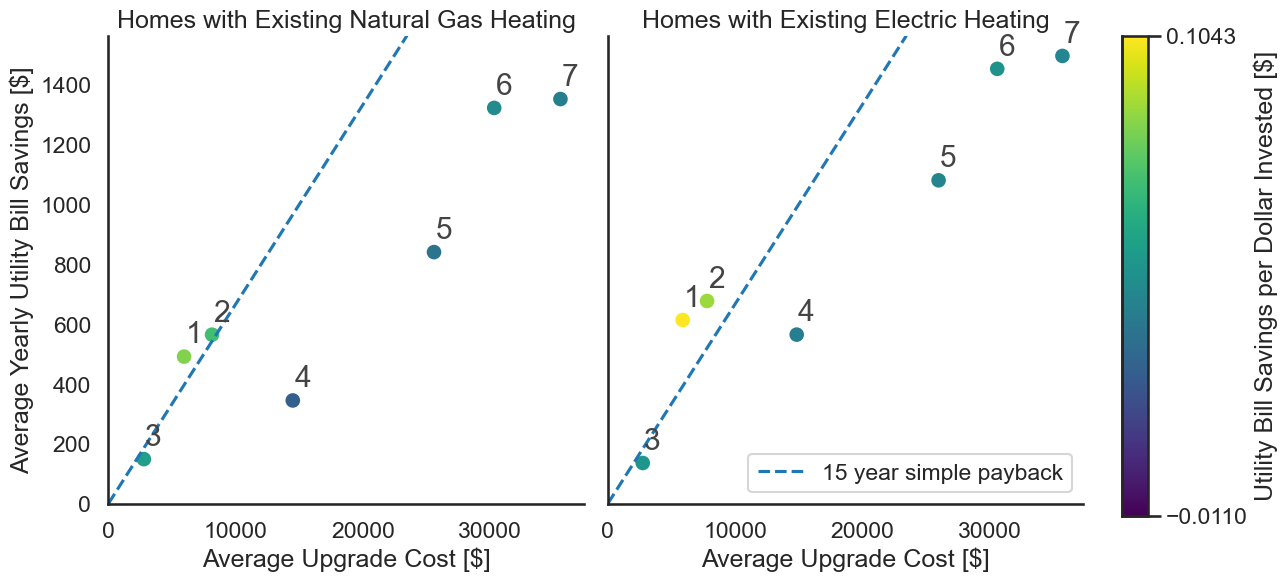

In [19]:
income = "0-80%AMI"
n_years = 15
my_upgrades = [5, 6, 4, 8, 10, 11, 15]
do_downselect = True

my_upgrade_names = savings.index[my_upgrades].values
n_segments = len(segment_names)
fig, axes = plt.subplots(nrows=1, ncols=n_segments, sharex=True, sharey=True, figsize=((6 * n_segments) + 1, 6))

ycols = {segment_num : f'segment{segment_num}_{income}_saving_bill_mean_usd' for segment_num in segment_names.keys()}
colorcols = {segment_num : f'segment{segment_num}_{income}_saving_bill_per_dollar_invested_usd' for segment_num in segment_names.keys()}
mincolor = savings[colorcols.values()].min().min()
maxcolor = savings[colorcols.values()].max().max()

fig.subplots_adjust(left=0.1, right=0.85, wspace=0.05, bottom=0.12, top=0.9)  # Make room for the colorbar
cbar_ax = fig.add_axes([0.88, 0.1, 0.02, 0.8])  # Position of the colorbar

for (segment_num, segment_name), ax in zip(segment_names.items(), axes):
    xcol = f'segment{segment_num}_{income}_upgrade_cost_mean_usd'
    ycol = ycols[segment_num]
    colorcol = colorcols[segment_num]
    if do_downselect:
        df = savings.loc[my_upgrade_names, [xcol, ycol, colorcol]]
    else:
        df = savings.loc[:, [xcol, ycol, colorcol]]

    ax.set_title(f"Homes with Existing {segment_name}")
    ax.scatter(df[xcol], df[ycol], c=df[colorcol], cmap='viridis', vmin=mincolor, vmax=maxcolor)
    ax.set_xlabel('Average Upgrade Cost [$]')

    for i, upg_name in enumerate(my_upgrade_names, 1):
        font_kw = {'fontsize': 'large', 'color': '#444'}
        ax.annotate(
            i,
            (df.at[upg_name, xcol], df.at[upg_name, ycol]),
            xytext=(1, 10),
            textcoords='offset points',
            **font_kw
        )
if do_downselect:
    xlims = axes[0].get_xlim()
    ylims = axes[0].get_ylim()
    for ax in axes[:2]:
        ax.plot([0, min(n_years * ylims[1], xlims[1])], [0, min(xlims[1] / n_years, ylims[1])], '--', label=f"{n_years} year simple payback")
    axes[0].set_xlim([0, xlims[1]])
    axes[0].set_ylim([0, ylims[1]])
    axes[1].legend(loc='lower right')

# Add a single colorbar
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax)
cbar.set_label('Utility Bill Savings per Dollar Invested [$]')
cbar.set_ticks([mincolor, maxcolor])  # Set the ticks on the colorbar

axes[0].set_ylabel('Average Yearly Utility Bill Savings [$]')
sns.despine()
filename = "upgrade_by_savings_downselect.svg" if do_downselect else "upgrade_by_savings_all.svg"
fig.savefig(results_path / filename)
for i, upg_name in enumerate(my_upgrade_names, 1):
    print(f"{i}: {upg_name}")